In [145]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
import pandas as pd
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import itertools

In [84]:
drugbank_mols =  Chem.SDMolSupplier('../../data/drugbank.sdf')
drugbank = [mol for mol in drugbank_mols if mol]
pd_drugbank = pd.DataFrame(drugbank, columns=["mol"])
pd_drugbank["Smiles"] = pd_drugbank.apply(lambda row: Chem.MolToSmiles(row["mol"]), axis=1)
pd_drugbank["Source"] = "drugbank"
pd_drugbank["ID"] = pd_drugbank.apply(lambda row: row["mol"].GetProp("DATABASE_ID"), axis=1)

[12:58:01] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:58:01] ERROR: Could not sanitize molecule ending on line 20009
[12:58:01] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:58:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:58:01] ERROR: Could not sanitize molecule ending on line 250947
[12:58:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:58:01] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:58:01] ERROR: Could not sanitize molecule ending on line 258130
[12:58:01] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:58:01] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:58:01] ERROR: Could not sanitize molecule ending on line 261581
[12:58:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:58:01] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[12:58:01] ERROR: Could not sanitize

In [92]:
pains = []
with open("../../data/pains/p_l15.txt", 'r') as inp:
    for line in inp:
        pain, name = line.strip().split("\t")
        pains.append((Chem.MolFromSmarts(pain), name))
        
with open("../../data/pains/p_m150.txt", 'r') as inp:
    for line in inp:
        pain, name = line.strip().split("\t")
        pains.append((Chem.MolFromSmarts(pain), name))
        
pains = [(p[0], p[1].split('"')[1]) for p in pains]

In [93]:
def filter_func(row):
    mol = row['mol']
    hits = [p[1] for p in pains if len(mol.GetSubstructMatches(p[0])) > 0]
    if len(hits) > 0:
        return "|".join(hits)
    else:
        return "0"

In [95]:
if "pains_hits" in pd_drugbank.columns:
        pd_drugbank.drop(columns=["pains_hits"], inplace=True)
        
df_data = pd.DataFrame(list(
    pd_drugbank.apply(filter_func, axis=1)),
    columns=["pains_hits"])
pd_drugbank = pd_drugbank.join(df_data)

In [96]:
pd_drugbank[pd_drugbank["pains_hits"] != "0"]["pains_hits"]

61          quinone_A(370)
141     anil_di_alk_C(246)
195         quinone_A(370)
211          styrene_A(13)
274         quinone_A(370)
               ...        
6877            azo_A(324)
6972        quinone_A(370)
7093        quinone_A(370)
7094        quinone_A(370)
7095        quinone_A(370)
Name: pains_hits, Length: 125, dtype: object

In [97]:
hits = pd_drugbank.apply(lambda row: [p[1] for p in pains if len(row['mol'].GetSubstructMatches(p[0])) > 0], axis=1)

In [98]:
hits = [hit for hit in hits if len(hit) > 0]

In [99]:
u_hits = set([h[0] for h in hits])
u_hits

{'acyl_het_A(9)',
 'anil_di_alk_B(251)',
 'anil_di_alk_C(246)',
 'anil_di_alk_D(198)',
 'azo_A(324)',
 'ene_rhod_A(235)',
 'imine_one_A(321)',
 'imine_one_isatin(189)',
 'keto_keto_beta_B(12)',
 'keto_phenone_A(11)',
 'quinone_A(370)',
 'quinone_D(2)',
 'steroid_A(2)',
 'styrene_A(13)',
 'styrene_B(8)'}

In [100]:
p_s = [p for p in pains if p[1] in u_hits]

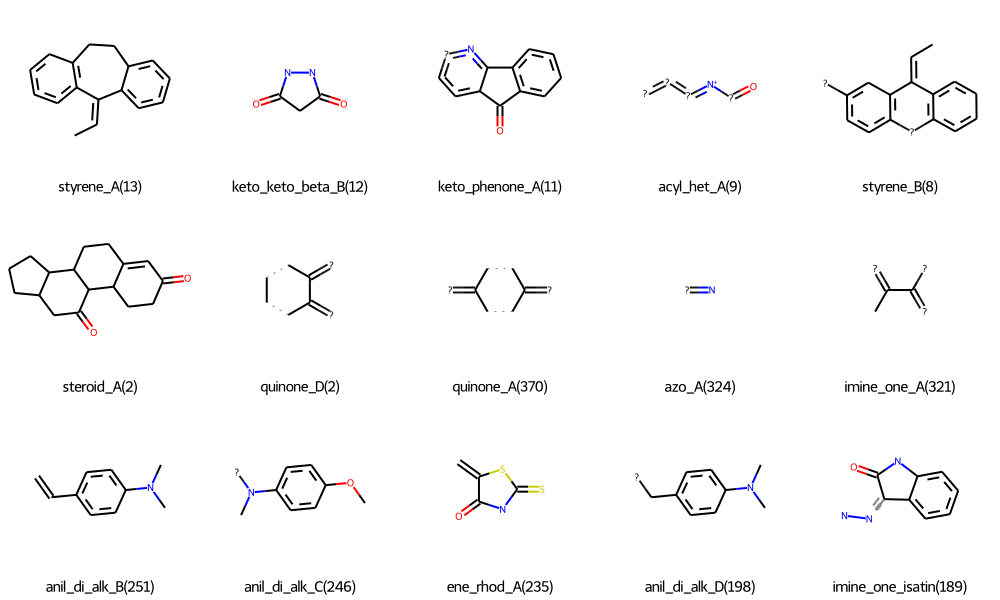

In [101]:
Draw.MolsToGridImage([p[0] for p in p_s], molsPerRow=5, subImgSize=(200, 200), legends=[p[1] for p in p_s])

In [104]:
names = {}
for i,p in enumerate(pains):
    names[p[1]] = i    

In [ ]:
def draw_func(row):
    mol = row["mol"]
    hits = row["pains_hits"].split("|")
    hits = [h.split('"')[1] for h in hits]

In [119]:
ps = pd.DataFrame(pd_drugbank[pd_drugbank["pains_hits"] != "0"])
ps.reset_index(drop=True, inplace=True)

In [165]:
idx = 5
mol = ps.iloc[idx]["mol"]
sub = pains[names[ps.iloc[idx]["pains_hits"]]][0]

In [192]:
def drawMolWithSub(mol, subs: list):
    sub_hist = []
    for sub in subs:
        hit_ats = list(mol.GetSubstructMatches(sub))
        hit_ats = [m1 for m in hit_ats for m1 in list(m)]
        sub_hist.append(hit_ats)
        
    hit_ats = list(set([m1 for m in sub_hist for m1 in m]))
    hit_bonds = []
    for idx1, idx2 in list(itertools.combinations(hit_ats, 2)):
        b = mol.GetBondBetweenAtoms(idx1, idx2)
        if b is not None:
            hit_bonds.append(mol.GetBondBetweenAtoms(idx1, idx2).GetIdx())
       
    d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                       highlightBonds=hit_bonds)
    d.FinishDrawing()
    return d

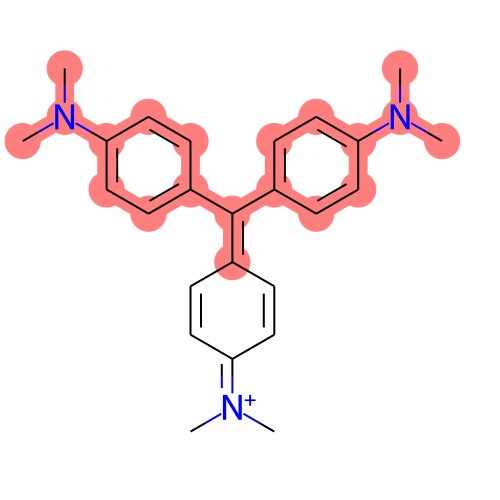

In [193]:
d = drawMolWithSub(mol, [sub])
SVG(d.GetDrawingText())